# Lib

In [150]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

from torchvision.datasets import MNIST

In [151]:
#os.chdir("/content/drive/MyDrive/AD Last Research")

# Helper Functions

In [152]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    #tsne = TSNE(n_components=2, random_state=0,  learning_rate='auto', init='random')
    tsne = TSNE(n_components=2, perplexity=50, n_iter=5000)
    x_2d = tsne.fit_transform(x)

    return x_2d

In [153]:
from sklearn.manifold import TSNE

def get_3d_tsne(x):
    tsne = TSNE(n_components=3, random_state=0,  learning_rate='auto', init='random')
    x_3d = tsne.fit_transform(x)

    return x_3d

In [154]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [155]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [156]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

# Network

In [157]:
class MLP(nn.Module):
    def __init__(self, init_features, hidden_features):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(init_features, 2*hidden_features),
            nn.ReLU(),
            nn.Linear(2*hidden_features, 1*hidden_features),
            nn.ReLU(),
            nn.Linear(1*hidden_features, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(
            x.flatten(1)
        )

In [158]:
class CNN_MLP(nn.Module):
    def __init__(self, img_size, channels, init_features=16):
        super(CNN_MLP, self).__init__()

        kernel_size, stride, padding = 3, 1, 1

        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv2d(channels, init_features * 1, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Layer 2
            nn.Conv2d(init_features * 1, init_features * 1, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Layer 3
            nn.Conv2d(init_features * 1, init_features * 2, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.hidden_features = int(
            ((img_size/2**3)**2)*(init_features * 2)
        )

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_features, int(self.hidden_features/2)),
            nn.ReLU(),
            nn.Linear(int(self.hidden_features/2), int(self.hidden_features/4)),
            nn.ReLU(),
            nn.Linear(int(self.hidden_features/4), 2),
        )

    def forward(self, x):
        return self.mlp(
            self.cnn(x).flatten(1)
        )

In [159]:
# TEST
N, C, H, W = 10,1,32,32
x = torch.empty(N, C, H, W).normal_(0.1).cuda()
net = CNN_MLP(32, 1, 16).cuda()

net(x).shape

torch.Size([10, 2])

In [160]:
count_parameters(net)

171602

# Data

In [161]:
from dataset import customdataset
from dataset.customdataset import get_dataset_2_classes
from torch.utils.data import ConcatDataset

In [162]:
img_size = 32
channels = 1
batch_size = 128
normal_label = 8
ano_label = 1

In [163]:
# Dataset
train_normal_ds, train_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=True,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

test_normal_ds, test_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=False,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

In [164]:
# Dataloader
train_ds = ConcatDataset([train_normal_ds, train_ano_ds])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


test_ds = ConcatDataset([test_normal_ds, test_ano_ds])
test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

# Train Two Classes Classifier

### Hyperparameters

In [165]:
device = 'cuda'
#hidden_features = 128 #mlp
hidden_features = 16 #cnn
num_class = 2

### All in One

In [166]:
# Nets
#net = MLP(img_size*img_size*channels, hidden_features).to(device)

net = CNN_MLP(img_size, channels, hidden_features).to(device)

In [167]:
# Loss & Optimizers
critic = nn.CrossEntropyLoss()
#critic = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

### Train

In [168]:
root_save = "F://GitHub//anomaly-detection//codes//Last Research//results//mlp_and_cnn_research//models_per_epochs"

In [169]:
device = 'cuda'

valid_loss_min = np.Inf
init_epoch = 0
num_epochs = 100
save_interval = 5

root_bp = "./results/vanilla_gan_research/last_parameters.pt"

info = torch.load(root_bp)
init_epoch = info['epoch']
generator.load_state_dict(info['state_dict_G'])
discriminator.load_state_dict(info['state_dict_D'])
optimizer_G.load_state_dict(info['optimizer_G'])
optimizer_D.load_state_dict(info['optimizer_D'])
save_tsne = info['save_tsne']

In [170]:
for i, (real_images, label) in enumerate(test_loader):
    real_images_test = real_images
    label_test = label
real_images_test = real_images_test.to(device)
label_test = label_test.to(device)

In [172]:
for epoch in range(1, num_epochs+1):
    train_loss = 0
    valid_loss = 0
    # TRAINING ###################################################################
    for i, (real_images, label) in enumerate(train_loader):
        # Preprocessing ##############################################
        real_images = real_images.to(device)
        label = label.to(device)
        net = net.to(device)
        net.train()
        optimizer.zero_grad()
        label_hat = net(real_images)
        #loss_bce = critic(label_hat.squeeze(1).to(torch.float), label)
        loss_cross = critic(label_hat, label)

        #features = net.cnn(real_images).flatten(1)
        #loss_sphere = ((features.norm(2, dim=1) - 1) ** 2).mean()
        #loss = loss_bce + 0.5*loss_sphere

        loss = loss_cross
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * real_images.size(0)

    train_loss = train_loss / len(train_loader.sampler)


    # TEST ###################################################################
    net.eval()

    label_hat_test = net(real_images_test)
    loss_cross = critic(label_hat_test, label_test)
    #loss_bce = critic(label_hat_test.squeeze(1).to(torch.float), label_test.to(torch.float))
    #features = net.cnn(real_images_test).flatten(1)
    #loss_sphere = ((features.norm(2, dim=1) - 1) ** 2).mean()

    #loss = loss_bce + 0.5*loss_sphere
    loss = loss_cross

    valid_loss = loss.item()
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

        torch.save(
            {
                "epoch": epoch,
                "state_dict_net": net.state_dict()
            }, f"mlp_epoch_{epoch}.pt"
        )

        torch.save(
        {
        "epoch": epoch,
        "state_dict_net": net.state_dict()
        }, root_save + f"//mlp_epoch_{epoch}.pt"
        )

Epoch: 1 	Training Loss: 0.128149 	Validation Loss: 0.009171
Validation loss decreased (inf --> 0.009171).  Saving model ...
Epoch: 2 	Training Loss: 0.009889 	Validation Loss: 0.001018
Validation loss decreased (0.009171 --> 0.001018).  Saving model ...
Epoch: 3 	Training Loss: 0.005443 	Validation Loss: 0.004829
Epoch: 4 	Training Loss: 0.007842 	Validation Loss: 0.001436
Epoch: 5 	Training Loss: 0.004037 	Validation Loss: 0.000150
Validation loss decreased (0.001018 --> 0.000150).  Saving model ...
Epoch: 6 	Training Loss: 0.002093 	Validation Loss: 0.000123
Validation loss decreased (0.000150 --> 0.000123).  Saving model ...
Epoch: 7 	Training Loss: 0.003230 	Validation Loss: 0.001879
Epoch: 8 	Training Loss: 0.026082 	Validation Loss: 0.002297
Epoch: 9 	Training Loss: 0.006501 	Validation Loss: 0.000423
Epoch: 10 	Training Loss: 0.004836 	Validation Loss: 0.003591
Epoch: 11 	Training Loss: 0.006224 	Validation Loss: 0.002594
Epoch: 12 	Training Loss: 0.003169 	Validation Loss: 0.0

KeyboardInterrupt: 

# Research on Net MLP

### Datas

In [173]:
# Dataset
test_normal_ds, test_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=False,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

In [174]:
# Dataloader
test_normal_loader = DataLoader(test_normal_ds, batch_size=len(test_normal_ds), shuffle=True)
test_ano_loader = DataLoader(test_ano_ds, batch_size=len(test_ano_ds), shuffle=True)

In [175]:
for i, (x, _) in enumerate(test_normal_loader):
    x_normal = x

In [176]:
for i, (x, _) in enumerate(test_ano_loader):
    x_ano = x

In [178]:
# Nets
epoch = 6
net = CNN_MLP(img_size, channels, hidden_features).to('cpu')
info = torch.load(root_save + f"//mlp_epoch_{epoch}.pt")
net.load_state_dict(info['state_dict_net'])

<All keys matched successfully>

In [179]:
net

CNN_MLP(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [183]:
net(x_ano)

tensor([[-7.0817, 11.3142],
        [-3.7807,  5.9602],
        [-5.2029,  8.6609],
        ...,
        [-5.7497,  9.5839],
        [-6.0808,  9.7675],
        [-6.1976, 10.3166]], grad_fn=<AddmmBackward0>)

In [184]:
from sklearn.decomposition import PCA

In [197]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, perplexity=7, learning_rate=1000, verbose=0, n_iter=3000, init='random')
    x_2d = tsne.fit_transform(x)

    return x_2d

In [194]:
from sklearn.manifold import TSNE

def get_3d_tsne(x):
    tsne = TSNE(n_components=3)
    x_3d = tsne.fit_transform(x)

    return x_3d

In [198]:
#features_normal = x_normal.flatten(1)
#features_ano = x_ano.flatten(1)
features_normal = net.cnn(x_normal).flatten(1)
features_ano = net.cnn(x_ano).flatten(1)

features_normal_2D = get_2d_tsne(features_normal.detach().cpu())
features_ano_2D = get_2d_tsne(features_ano.detach().cpu())

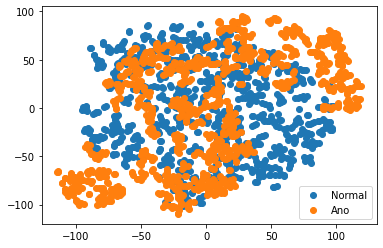

In [199]:
plt.figure()
plt.scatter((features_normal_2D[:, 0]), (features_normal_2D[:, 1]), label='Normal')
plt.scatter((features_ano_2D[:, 0]), (features_ano_2D[:, 1]), label='Ano')
plt.legend()

In [127]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

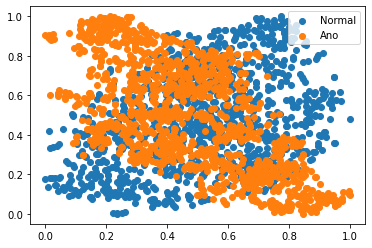

In [128]:
plt.figure()
plt.scatter(scale_to_01_range(features_normal_2D[:, 0]), scale_to_01_range(features_normal_2D[:, 1]), label='Normal')
plt.scatter(scale_to_01_range(features_ano_2D[:, 0]), scale_to_01_range(features_ano_2D[:, 1]), label='Ano')
plt.legend()

In [236]:
net(x_normal) < 1*torch.zeros_like(net(x_normal))

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


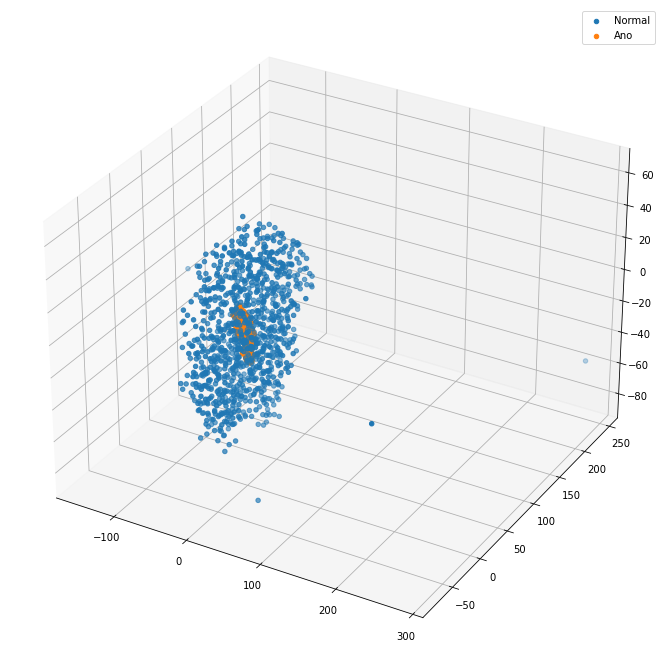

In [189]:
#features_normal = x_normal.flatten(1)
#features_ano = x_ano.flatten(1)

features_normal = net.cnn(x_normal).flatten(1)
features_ano = net.cnn(x_ano).flatten(1)

features_normal_3D = get_3d_tsne(features_normal.detach().cpu())
features_ano_3D = get_3d_tsne(features_ano.detach().cpu())


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_normal_3D[:, 0], features_normal_3D[:, 1], features_normal_3D[:, 2], label='Normal')
ax.scatter(features_ano_3D[:, 0], features_ano_3D[:, 1], features_ano_3D[:, 2], label='Ano')
plt.legend()
plt.show()

In [142]:
# FOR MLP
output_layer = 3

#features_normal = x_normal.flatten(1)
#features_ano = x_ano.flatten(1)

features_normal = net.mlp[:output_layer+1](x_normal.flatten(1))
features_ano = net.mlp[:output_layer+1](x_ano.flatten(1))

features_normal_2D = get_2d_tsne(features_normal.detach().cpu())
features_ano_2D = get_2d_tsne(features_ano.detach().cpu())


plt.figure()
plt.scatter(features_normal_2D[:, 0], features_normal_2D[:, 1], label='Normal')
plt.scatter(features_ano_2D[:, 0], features_ano_2D[:, 1], label='Ano')
plt.legend()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (974x1024 and 2048x1)

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


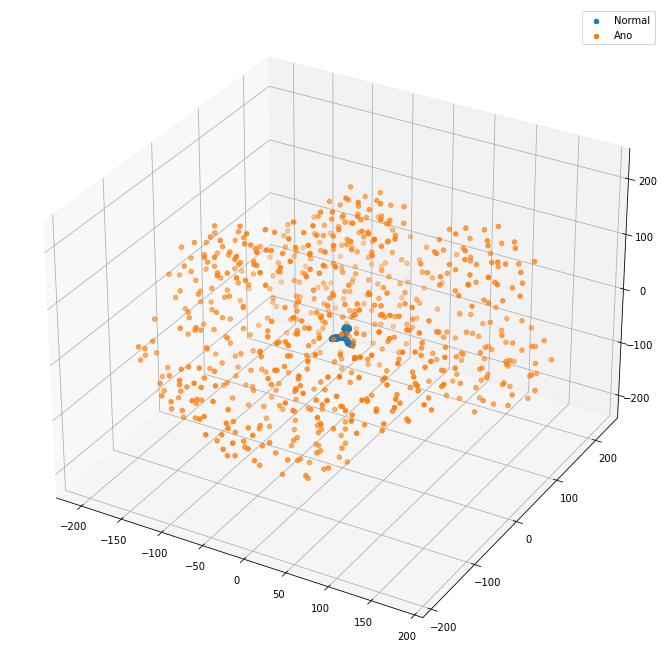

In [41]:
output_layer = 5

#features_normal = x_normal.flatten(1)
#features_ano = x_ano.flatten(1)

features_normal = net.mlp[:output_layer+1](x_normal.flatten(1))
features_ano = net.mlp[:output_layer+1](x_ano.flatten(1))

features_normal_3D = get_3d_tsne(features_normal.detach().cpu())
features_ano_3D = get_3d_tsne(features_ano.detach().cpu())


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_normal_3D[:, 0], features_normal_3D[:, 1], features_normal_3D[:, 2], label='Normal')
ax.scatter(features_ano_3D[:, 0], features_ano_3D[:, 1], features_ano_3D[:, 2], label='Ano')
plt.legend()
plt.show()